In [1]:
import os
import re
import gzip
from PIL import Image

import nibabel as nib
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF

from src.config import Directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter
from src.utils import synthetic_occlusion

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

max_images 5000


In [2]:
unet_filename = 'unet_liver_2020-10-31_19:19:13.pth'
path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet.load_state_dict(torch.load(path_to_unet, map_location=device)['model_state_dict'])
unet.get_features()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_si

In [2]:
%%time
# vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine', 'out')
vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine')
regex = re.compile('.*\.nii\.gz')
names = [f for f in sorted(os.listdir(vol_dir)) if regex.match(f) if 'volume-25' not in f]
slices = []
slice_range = (-5, 5)

for name in names:
        
    fp = os.path.join(vol_dir, name)
    with gzip.open(fp, 'rb') as f:

        niftii_object = nib.load(f.filename)
        volume = np.array(niftii_object.dataobj, dtype=np.int16)
        
        num_slices = volume.shape[2]
        amount = np.zeros(num_slices)

        for i in range(num_slices):

            s = volume[...,i]
            background = s.min()
            amount[i] = np.sum(s==background)
        
        idx = np.argmin(amount)
#         idx = 60

        curr_slices = volume[..., idx+slice_range[0]:idx+slice_range[1]]

        curr_slices = apply_ct_abdomen_filter(curr_slices)

        curr_min, curr_max = curr_slices.min(), curr_slices.max()
        curr_slices = (curr_slices - curr_min) / (curr_max - curr_min + 1e-12)

        curr_slices = np.transpose(curr_slices, (2, 0, 1))
        curr_slices = np.stack((curr_slices, curr_slices, curr_slices), axis=len(curr_slices.shape))
        curr_slices = np.rot90(curr_slices, k=1, axes=(1,2))
        curr_slices = curr_slices.astype(np.float32)

        slices.extend(curr_slices)

slices = np.asarray(slices)
train_slices, test_slices = train_test_split(slices, test_size=0.2, random_state=42)

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)
synthetic_images = synthetic_occlusion(test_slices, textured=False)

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: use the name attribute
  del sys.path[0]


CPU times: user 5.78 s, sys: 3.38 s, total: 9.16 s
Wall time: 22.3 s


In [15]:
im = (test_slices[26]*255).astype(np.uint8)
im = Image.fromarray(im)
im.save('./real_liver_slice.png')
# plt.imshow(im)

In [49]:
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                     max_it=1000, tol=5e-12,
                                     u_out_name='chaos_pool5_128_u_test_8.pickle',
                                     p_out_name='chaos_pool5_128_p_test_8.pickle')

In [50]:
save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name='test_8',
                    max_num_clusters=20)

Saving top 16 images for each cluster


In [ ]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, 'test_8',
                                       sim_dir_name='similarity_vgg_pool5_chaos_8',
                                       u_out_name='chaos_pool5_128_u_test_8.pickle',
                                       N_sub=min(200, len(dataset)//10), num_layer_features=min(100, len(dataset)))

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.2
iter 1/11 1/11
comptSimMat iter time: 1.4099314093589783
iter 1/11 2/11
comptSimMat iter time: 2.933709442615509
iter 1/11 3/11
comptSimMat iter time: 3.0360178550084433
iter 1/11 4/11


In [ ]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name='test_8',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name='similarity_vgg_pool5_chaos_8',
                    dict_filename='chaos_pool5_128_u_test_8.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_8/',
                    im_channels=3)

# Localize Occluders on Synthetic

In [3]:
from torchvision import models
from PIL import Image
import cv2

from CompositionalNets.Code.config import categories, data_path, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel, update_clutter_model
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map, eval_occ_detection
from CompositionalNets.Code.losses import ClusterLoss
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [5]:
extractor[:12]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
)

In [71]:
im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice0.png'))
im = (np.array(im).astype(np.float32) / 255)[...,:3]
im[200:300, 100:200] = 0.78431374
synthetic_images[0] = im

im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice1.png'))
im = (np.array(im).astype(np.float32) / 255)[...,:3]
im[150:200, 200:300] = 0.82431374
synthetic_images[1] = im

im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice2.jpg'))
im = (np.array(im).astype(np.float32) / 255)
im[200:300, 100:200] = 0.86431374
synthetic_images[2] = im

im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice3.jpg'))
im = (np.array(im).astype(np.float32) / 255)
synthetic_images[3] = im

im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice4.jpg'))
im = (np.array(im).astype(np.float32) / 255)
synthetic_images[4] = im

im = Image.open(os.path.join(Directories.DATA, 'tumors', 'tumor_slice5.jpg'))
im = (np.array(im).astype(np.float32) / 255)
synthetic_images[5] = im

In [103]:
f_map = extractor[:10](torch.Tensor(synthetic_images[5]).permute(2, 0, 1).unsqueeze(0).cuda())
f_map = f_map.detach().squeeze().permute(1, 2, 0).cpu().numpy()
f_map = (f_map - f_map.min()) / (f_map.max() - f_map.min())

In [ ]:
nrows, ncols = 16, 16
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.imshow(f_map[...,i+j], cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.savefig('f_map_activations6.png')
plt.show()

In [4]:
%%time
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(Directories.COMPOSITIONAL_NETS,
                        'models/init_vgg/dictionary_vgg/chaos_pool5_128_u_test_8.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(Directories.COMPOSITIONAL_NETS, 
                             'models/init_vgg/mix_model_vmf_chaos_EM_all_test_8/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer,
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD)
if device_ids:
    model.to(device_ids[0])

Early stop at iter 2, llk 28.329079492744288
CPU times: user 566 ms, sys: 89.1 ms, total: 655 ms
Wall time: 1.2 s


In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
for image in synthetic_images:

    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    with torch.no_grad():
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
    
    occ_map = occ_maps[0].detach().cpu().numpy()
    occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
    occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

    img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    faco = img_orig.shape[0] / occ_img.shape[0]

    occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))

    canvas = np.concatenate((img_orig, occ_img_s), axis=1)
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas)
    plt.axis('off')
    fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
    cv2.imwrite(fp, canvas)

# Localize Real Tumors

In [103]:
tumor_dir = os.path.join(Directories.DATA, 'tumors')
tumors = [cv2.imread(os.path.join(tumor_dir, name)) for name in os.listdir(tumor_dir)]

In [15]:
train_hdf5_fp = os.path.join(Directories.LITS, 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][40:60]
    target_dataset = hf['masks'][40:60]

tumors = []
for im in image_dataset:
    im = apply_ct_abdomen_filter(im)
    
    im = np.stack((im, im, im), axis=2)

    # Normalize between 0 and 1
    im = (im - im.min()) / (im.max() - im.min())
    im = im.astype(np.float32)
    tumors.append(im)

unet_filename = 'unet_liver_2020-08-13_15:52:08.pth'
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")

path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

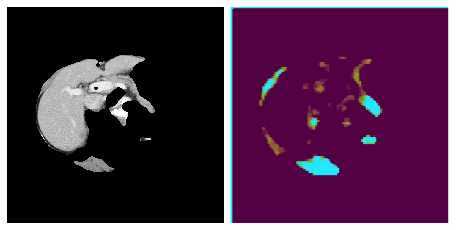

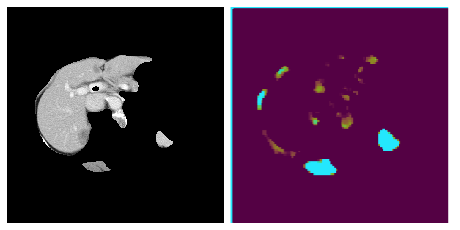

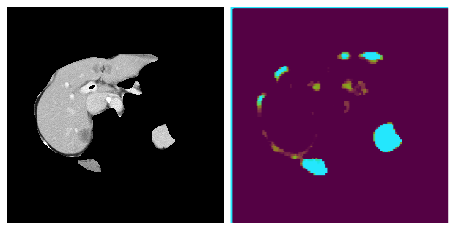

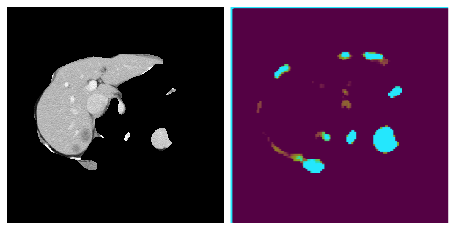

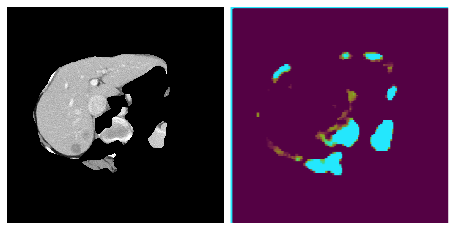

In [20]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in tumors[:5]:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        out = unet(image)
        scores = F.softmax(out, dim=1)

        segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        processed_images = segmentations.unsqueeze(1) * image
        
        seg_liver = processed_images.squeeze()
        image = seg_liver.unsqueeze(0)

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
        cv2.imwrite(fp, canvas)

In [35]:
# vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine', 'out')
vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine')
regex = re.compile('.*\.nii\.gz')
slices = []

for name in sorted(os.listdir(vol_dir)):
    
    if regex.match(name):
        
        fp = os.path.join(vol_dir, name)
        with gzip.open(fp, 'rb') as f:
            
            niftii_object = nib.load(f.filename)
            volume = np.array(niftii_object.dataobj, dtype=np.int16)
            
#             num_slices = volume.shape[2]
#             amount = np.zeros(num_slices)
            
#             for i in range(num_slices):
                
#                 s = vol_array[...,i]
#                 background = s.min()
#                 amount[i] = np.sum(s==background)
            
#             idx = np.argmin(amount)

            idx = 60
            curr_slices = volume[..., idx-10:idx+10].transpose(2, 0, 1)
            vol_min, vol_max = volume.min(), volume.max()
            for curr_slice in curr_slices:
            
#             curr_slice = vol_array[...,np.argmin(amount)]
                curr_slice = apply_ct_abdomen_filter(curr_slice)
                curr_slice = np.rot90(curr_slice, k=1)
                curr_slice = np.stack((curr_slice, curr_slice, curr_slice), axis=2)

                # Normalize between 0 and 1
                curr_slice = (curr_slice - vol_min) / (vol_max - vol_min + 1e-12)
                curr_slice = curr_slice.astype(np.float32)
                slices.append(curr_slice)
            
slices = np.asarray(slices)
train_slices, test_slices = train_test_split(slices, test_size=0.2, random_state=42)

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: use the name attribute
  del sys.path[0]


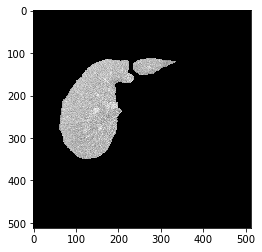

In [36]:
plt.imshow(curr_slice)